## Imports

In [1]:
#from __future__ import print_function, division

import torch
import torch.nn.parallel
import torch.utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import matplotlib.pyplot as plt
import time

from PIL import Image
import DrawingWithTensors

from torchvision.transforms import ToPILImage
#from IPython.display import Image
#to_img = ToPILImage()
#from IPython.display import Image

#plt.ion()   # interactive mode

#original code for training: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#imports related to fully convolutional network
import torchfcn

#original paths for FCNs:
#/home/peo5032/data/models/chainer/fcn16s_from_caffe.npz
# calling torchfcn.models.FCN16s.pretrained_model yields:
# might need to call download on it first: torchfcn.models.FCN16s.download()
#'/home/peo5032/data/models/pytorch/fcn16s_from_caffe.pth'

PRETRAINED_PATH = '/home/peo5032/data/models/pytorch/fcn16s_from_caffe.pth'
NUM_CLASSES = 7
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu" #just for testing for sunlab

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:
#https://github.com/GautamSridhar/FCN-implementation-on-Pytorch/blob/master/DiceLoss.py
class Dice_loss(torch.nn.Module):
    def __init__(self,type_weight=None,weights=None,ignore_index=None):
        super(Dice_loss,self).__init__()
        self.type_weight = type_weight
        self.weights=weights
        self.ignore_index=ignore_index

    def forward(output, target):
        """
        output : NxCxHxW Variable
        target :  NxHxW LongTensor
        type_weight : weights calculated according to the size of each segmented portion
        weights : C FloatTensor
        ignore_index : int index to ignore from loss
        """
        """
        Need to add ways to incorporate the weights that change according
        to the number of voxels attached to a particular label
        """
        eps = 0.0001

        encoded_target = output.detach() * 0

        if ignore_index is not None: 
            mask = target == ignore_index                        #creates a one hot encoding that masks a particular index
            target = target.clone()
            target[mask] = 0
            encoded_target.scatter_(1, target.unsqueeze(1), 1)
            mask = mask.unsqueeze(1).expand_as(encoded_target)
            encoded_target[mask] = 0
        else:
            encoded_target.scatter_(1, target.unsqueeze(1), 1)   #creates a one hot encoding from the given target images   

        if weights is None:
            weights = 1

        ref_vol = encoded_target.sum(0)                          # creates an appropriate weight map that can be multiplied

        if type_weight == 'Square':
            weight_map = torch.reciprocal(ref_vol**2)
        if type_weight == 'Simple':
            weight_map = torch.reciprocal(ref_vol)

        new_weight_map = weight_map
        new_weight_map[weight_map == float("Inf")] = 0           # Converting all reciprocal infinities to max values
        m = torch.max(new_weight_map)
        new_weight_map[weight_map == float("Inf")] = m

        intersection = output * encoded_target
        numerator = 2 * (new_weight_map*intersection.sum(0)).sum(1).sum(1)
        denominator = output + encoded_target

        if ignore_index is not None:
            denominator[mask] = 0
        denominator = (new_weight_map * denominator.sum(0)).sum(1).sum(1) + eps
        
        loss_per_channel = weights * (1 - (numerator / denominator))
        return loss_per_channel.sum() / output.size(1)


In [4]:
#https://github.com/iCopyPasta/Pytorch-UNet/blob/master/dice_loss.py

import torch
from torch.autograd import Function, Variable

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_tensors
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union + self.inter) \
                         / self.union * self.union
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


    def dice_coeff(input, target):
        """Dice coeff for batches"""
        if input.is_cuda:
            s = torch.FloatTensor(1).cuda().zero_()
        else:
            s = torch.FloatTensor(1).zero_()

        for i, c in enumerate(zip(input, target)):
            s = s + DiceCoeff().forward(c[0], c[1])

        return s / (i + 1)

## Load Data

In [5]:
imageSize = 400
batchSize = 2
data_transforms = transforms.Compose([transforms.Resize([imageSize,imageSize]),transforms.ToTensor()
                                     ])
iteration = str(1)

# instantiate the dataset and dataloader
data_dir = '/home/peo5032/Documents/COMP594/input/gen'+iteration
dataset = ImageFolderWithPaths(data_dir, transform=data_transforms) # our custom dataset
dataloaders = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle=True, num_workers=1)


# iterate over data
#for inputs, labels, paths in dataloader:
#    # use the above variables freely
#    print(inputs, labels, paths)

#groundTruth = tensor
#label = tensor[0,0]
#path = tuple list, access each via path[index]

new_road_factory = DrawingWithTensors.datasetFactory()

## Training Routine without Validation Steps

In [6]:
outsideViewing = None

def train_model(model, criterion, optimizer, scheduler, num_epochs=4):
    since = time.time()

    best_model_wts = model.state_dict().copy()
    best_acc = 0.0
    
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        scheduler.step()
        
        running_loss = 0.0
        running_corrects = 0
               
        #BATCH TUPLE
        inputs, labels, paths = next(iter(dataloaders))
        inputs.to(device)
                
        #build ground-truth batch tensor
        for locations in paths:
            i = 0
            #dtype=torch.int64
            labels = torch.zeros(batchSize,NUM_CLASSES,imageSize,imageSize, dtype = torch.float32)
            labels[i] = torch.load(locations.replace(".png", ".pt").replace("roads", "tensor_values")) #manually fetch your own tensor values here somehow? 
            i += 1
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        # TODO: ENSURE OUTPUTS AND GROUNDTRUTH ARE THE SAME
        with torch.set_grad_enabled(True):
            #build input-truth batch tensor
            outputs = model(inputs)
            loss = criterion(outputs, labels) #ground truth comparison

            # backward + optimize 
            loss.backward(retain_graph=True)
            optimizer.step()
            
        # statistics
        epoch_loss = loss.item() * inputs.size(0) # unsure what this part is
        print('epoch loss:',epoch_loss)
        
        
            
        #running_corrects += torch.sum(preds == labels.data) # unsure what this part is

        #epoch_loss = running_loss / dataset_sizes[phase]
        #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
        #epoch_loss = running_loss / dataset_sizes[phase]
        #epoch_acc = running_corrects.double() / dataset_sizes[phase]

        #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        #phase, running_loss, ))

        # deep copy the model
        #if phase == 'val' and epoch_acc > best_acc:
        #    best_acc = epoch_acc
        #    best_model_wts = copy.deepcopy(model.state_dict())
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model

## Load Pretrained Model

In [7]:
model = torchfcn.models.FCN16s()
model.load_state_dict(torch.load(PRETRAINED_PATH))
model = model.to(device)
#look at model architecture
#model

In [8]:
model

FCN16s(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

## Change Architecture for New Classes

In [9]:
model.score_fr = torch.nn.Conv2d(4096, NUM_CLASSES , kernel_size=(1, 1), stride=(1, 1))
torch.nn.init.uniform(model.score_fr.weight, a=0, b=0.35)
#model.score_fr.weight.data.fill_(0.10)
#model.score_fr.bias.data.fill_(0.00)

model.score_pool4 = torch.nn.Conv2d(512, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
torch.nn.init.uniform(model.score_pool4.weight, a=0, b=0.35)
#model.score_pool4.weight.data.fill_(0.10)
#model.score_pool4.bias.data.fill_(0.00)

model.upscore2 = torch.nn.ConvTranspose2d(NUM_CLASSES, NUM_CLASSES, kernel_size=(4, 4), stride=(2, 2), bias=False)
torch.nn.init.uniform(model.upscore2.weight, a=0, b=0.35)
#model.upscore2.weight.data.fill_(0.10)

model.upscore16 = torch.nn.ConvTranspose2d(NUM_CLASSES, NUM_CLASSES, kernel_size=(32, 32), stride=(16, 16), bias=False)
torch.nn.init.uniform(model.upscore16.weight, a=0, b=0.35)
#model.upscore16.weight.data.fill_(0.10)


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  import sys
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  if sys.path[0] == '':
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  app.launch_new_instance()


Parameter containing:
tensor([[[[0.1437, 0.3040, 0.2127,  ..., 0.1069, 0.2785, 0.1997],
          [0.1228, 0.0734, 0.1503,  ..., 0.1376, 0.1671, 0.2880],
          [0.2934, 0.1178, 0.2177,  ..., 0.0773, 0.0925, 0.1399],
          ...,
          [0.3163, 0.1180, 0.0439,  ..., 0.1830, 0.2495, 0.0963],
          [0.2188, 0.0406, 0.0741,  ..., 0.0058, 0.0624, 0.2946],
          [0.1257, 0.2865, 0.1333,  ..., 0.2733, 0.2565, 0.1833]],

         [[0.3028, 0.0991, 0.1301,  ..., 0.2781, 0.3137, 0.1533],
          [0.1127, 0.2566, 0.0157,  ..., 0.2937, 0.1079, 0.0604],
          [0.2437, 0.3477, 0.2487,  ..., 0.0610, 0.0749, 0.3180],
          ...,
          [0.2147, 0.1937, 0.3194,  ..., 0.0388, 0.2235, 0.2749],
          [0.2501, 0.0561, 0.2410,  ..., 0.2993, 0.2779, 0.1289],
          [0.1013, 0.0875, 0.1412,  ..., 0.0063, 0.1754, 0.3241]],

         [[0.1448, 0.2144, 0.1042,  ..., 0.3246, 0.2448, 0.1809],
          [0.1430, 0.1782, 0.1810,  ..., 0.1374, 0.2562, 0.1415],
          [0.1094, 0

In [10]:
#model.upscore16.weight

## Training and Results

In [11]:
#criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()
#criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.NLLLoss()
criterion = DiceCoeff()


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(),amsgrad=True)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [12]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
epoch loss: 0.7278448343276978
Epoch 1/24
----------
epoch loss: 0.6753778457641602
Epoch 2/24
----------
epoch loss: 0.6771224141120911
Epoch 3/24
----------
epoch loss: 0.894478976726532
Epoch 4/24
----------
epoch loss: 0.7450429201126099
Epoch 5/24
----------
epoch loss: 0.9346529841423035
Epoch 6/24
----------
epoch loss: 0.9201035499572754
Epoch 7/24
----------
epoch loss: 0.6647546887397766
Epoch 8/24
----------
epoch loss: 0.6848224997520447
Epoch 9/24
----------
epoch loss: 0.47680774331092834
Epoch 10/24
----------
epoch loss: 0.8080872297286987
Epoch 11/24
----------
epoch loss: 0.5795480012893677
Epoch 12/24
----------
epoch loss: 0.8153401017189026
Epoch 13/24
----------
epoch loss: 0.7476489543914795
Epoch 14/24
----------
epoch loss: 0.8514634966850281
Epoch 15/24
----------
epoch loss: 0.6331270337104797
Epoch 16/24
----------
epoch loss: 0.7794377207756042
Epoch 17/24
----------
epoch loss: 0.6992269158363342
Epoch 18/24
----------
epoch loss: 0.8

## Inference Eval

In [13]:
#show us the goods of our progress



print("showing inference during training to ensure works")
print('using /home/peo5032/Pictures/2_9.31_b.png')


#img = Image.open('/home/peo5032/Pictures/4.png')
img = Image.open('/home/peo5032/Documents/COMP594/URBAN_IMAGES/101_244.0_b.png')
resultTensor = torch.zeros(2,3,400,400)

resultTensor[0] = torchvision.transforms.ToTensor()(torchvision.transforms.Resize([imageSize,imageSize])(img))
resultTensor[1] = torchvision.transforms.ToTensor()(torchvision.transforms.Resize([imageSize,imageSize])(img))

outputs = model(resultTensor)



showing inference during training to ensure works
using /home/peo5032/Pictures/2_9.31_b.png


In [14]:
def showClassLabaelOnImage(img, tensor, class_label):
    IMAGE_SIZE = 400
    imgTMP = img.copy()
    imgMap = imgTMP.load()
    class_type_corresponding_channel = new_road_factory.classMap[class_label]
    print(class_type_corresponding_channel)    
    for i in range(0, IMAGE_SIZE):
        for j in range(0, IMAGE_SIZE):
            if tensor[class_type_corresponding_channel, i,j] >= 0.65:
                #show class label in white
                imgMap[i,j] = (0,0,0)
        
    return imgTMP

5


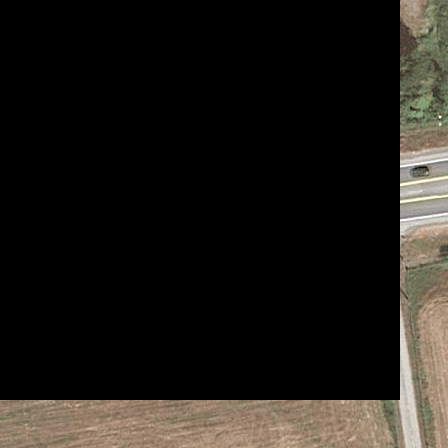

In [15]:
#0- "background"
#1- "left-shoulder",
#2- "left-yellow-line-marker",
#3- "white-lane-markers",
#4- "lane",
#5- "right-white-line-marker",
#6- "right-shoulder"

showClassLabaelOnImage(img, outputs[0] , "right-white-line-marker")

In [16]:
torch.max(outputs[0][0])

tensor(264.2390, grad_fn=<MaxBackward1>)

In [17]:
torch.equal(outputs[0][0], outputs[0][2])

False

In [18]:
outputs[0][1]

tensor([[136.5473, 155.3565, 133.9659,  ..., 164.2892, 148.9708, 145.5695],
        [137.3331, 192.6041, 177.8992,  ..., 187.4738, 178.3571, 149.8698],
        [157.5509, 170.4016, 125.3670,  ..., 131.9794, 138.8580, 164.4339],
        ...,
        [143.4872, 146.7482, 143.5068,  ..., 203.1160, 193.8801, 180.4701],
        [162.3627, 120.6718, 143.4705,  ..., 135.7471, 164.3956, 180.0753],
        [167.6640, 143.8914, 157.2946,  ..., 171.1600, 149.1487, 161.9202]],
       grad_fn=<SelectBackward>)

In [19]:
torch.save(model, "/home/peo5032/Documents/COMP594/model.pt")